In [1]:
!pip install opencv-python
!pip install mediapipe
!pip install scikit-learn
!pip install cvzone

# 1. Importing libraries and defining dataset

In [2]:
# For capturing hand coordinates
import cv2
import cvzone
import mediapipe as mp

# For processing data
import pandas as pd
import numpy as np

#For check file
import os
import time
import webbrowser

In [3]:
# dataset = pd.read_csv('./Dataset/hand_dataset_1000_24.csv')
# dataset = pd.read_csv('./Dataset/hand_dataset_3000.csv')
dataset = pd.read_csv('./Dataset/hand_dataset_MAI_3000.csv')
# dataset = pd.read_csv('./Dataset/hand_dataset_MAI_3000_space_del.csv')

# Show dataset first five data
dataset.head()

,class,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x17,y17,x18,y18,x19,y19,x20,y20,x21,y21
0,A,0.530803,0.581163,0.413990,0.501149,0.355407,0.369223,0.345517,0.263534,0.354250,...,0.534037,0.476981,0.665000,0.338577,0.605741,0.320499,0.588447,0.400885,0.594126,0.455363
1,A,0.503664,0.616673,0.377512,0.536617,0.317852,0.408111,0.306450,0.296595,0.316670,...,0.494619,0.508490,0.635405,0.349954,0.561715,0.359349,0.546541,0.440563,0.551058,0.498263
2,A,0.267808,0.670679,0.187360,0.610215,0.141140,0.503103,0.133638,0.422246,0.138989,...,0.298920,0.586336,0.368706,0.504098,0.369881,0.461587,0.362212,0.517269,0.349507,0.565708
3,A,0.289091,0.751779,0.167962,0.654705,0.100007,0.499485,0.095107,0.371244,0.122449,...,0.294725,0.624627,0.457846,0.480413,0.393687,0.455553,0.365366,0.547497,0.356335,0.612805
4,A,0.285160,0.762803,0.161197,0.667723,0.094453,0.512100,0.090644,0.383932,0.113567,...,0.292644,0.635424,0.450271,0.489606,0.388296,0.466932,0.361084,0.560643,0.352804,0.623975


In [4]:
# Show dataset overview, should return 1000 for each alphabet (excluding y and z)
dataset['class'].value_counts()

I    2393
A    2180
M    1675
Name: class, dtype: int64

# 2. Creating Train and Test Data
- We use *train_test_split* since we don't really have test dataset.
- Normalizing dataset can be ignored, since we predict our data directly using raw handlandmark. 

In [5]:
# Defining X and Y from dataset for training and testing

X = dataset.iloc[:, 1:].values
Y = dataset.iloc[:, 0].values

In [6]:
from sklearn.model_selection import train_test_split

# We will take 33% from 1000 for our test data.
# Recommended value 80:20, 67:33, 50:50
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.80)

In [7]:
#Normalize / Standarize dataset

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 3. Creating classifier model for our alphabet recognition.
- *n_neighbors* can be adjusted as we provide graph for mean errors for each *n_neighbors*

In [8]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

# 4. Calculate model accuracy

In [9]:
y_pred = classifier.predict(X_test)

In [10]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.94      0.99      0.97      1721
           I       0.99      0.99      0.99      1928
           M       0.99      0.91      0.95      1350

    accuracy                           0.97      4999
   macro avg       0.97      0.97      0.97      4999
weighted avg       0.97      0.97      0.97      4999

0.9701940388077616


# 5. Show graph for adjusting number of *n_neighbors*

In [11]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

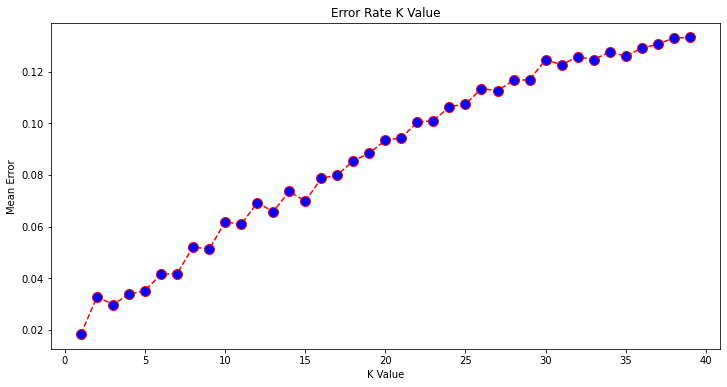

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# 6. Intialize Mediapipe Hands for alphabet recognition.

In [13]:
# Initialize mediapipe hand

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

# init Check Var MAI
M = False
A = False
I = False

In [14]:
result = []
# Count File In Folder
def countFile(Ipath):
    initial_count = 0
    for path in os.listdir(Ipath):
        if os.path.isfile(os.path.join(Ipath, path)):
            initial_count += 1
    return initial_count
# Create Function to Detect complete label "M","A","I"
def isComplete():
    if(M == True and A == True and I == True):
        return True
    else:
        return False
def checkAlpha(alph,checkOnLabel):
    global result
    result.append(alph)
    if(len(result)>=2):
        if(result[len(result)-1] == result[len(result)-2] and result[len(result)-1] == checkOnLabel):
            return True
        else:
            return False
    else:
        return False
def DisplayCheckAlpha():
    global M
    global A
    global I
    result = "_|_|_"
    arr = result.split("|");
    if(M==True):
        arr[0]="M"
    if(A==True):
        arr[1]="A"
    if(I==True):
        arr[2]="I"
    print("M : "+str(M)+" A : "+str(A)+" I : "+str(I))
    return arr[0]+arr[1]+arr[2]
# Write detect file
def writeFile(iAlpha,img):
    BasePath = "./archive/ceremony/"+iAlpha
    isExist = os.path.exists(BasePath)
    if not isExist:
        os.makedirs(BasePath)
    cv2.imwrite(os.path.join(BasePath, f'{countFile(BasePath):04d}' +'.jpg'), img)
def __draw_label(img, text, pos, bg_color,text_color=(0, 0, 0)):
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    scale = 5
    color = text_color
    thickness = cv2.FILLED
    margin = 2

    txt_size = cv2.getTextSize(text, font_face, scale, thickness)

    end_x = pos[0] + txt_size[0][0] + margin
    end_y = pos[1] - txt_size[0][1] - margin-20

    cv2.rectangle(img, (pos[0],pos[1]+20), (end_x, end_y), bg_color, thickness)
    cv2.putText(img, text, pos, font_face, scale, color, 10, cv2.LINE_AA)

In [15]:
def DetectionAlpha(currentProjectLabel,videoRecorderIndex,windowpositionX,windowpositionY):
    cap = cv2.VideoCapture(videoRecorderIndex)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    success,img = cap.read()
    isStartCheck = False
    checkedImg = cv2.imread('./images/static/checked.png', cv2.IMREAD_UNCHANGED)
    checkedImg = cv2.resize(checkedImg,(0,0),None,0.1,0.1)
    overlay = cv2.imread('./images/static/'+currentProjectLabel+'_Hand.png', cv2.IMREAD_UNCHANGED)
    overlay = cv2.resize(overlay,(0,0),None,1,1)
    hf,wh,cf = overlay.shape
    hb,wb,cb = img.shape
    hc,wc,cc = checkedImg.shape
    captureImg = img
    prepareWin = "Hand Tracking"
    isComplete = False
    with mp_hands.Hands(
        max_num_hands = 1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as hands:
        start_time = time.time()
        DELAY_SECONDS = 5
        t1 = time.time()
        while cap.isOpened():
            success, image = cap.read()

            if not success:
                print("Ignoring empty camera frame.")
                # If loading a video, use 'break' instead of 'continue'.
                continue
            # Flip the image horizontally for a later selfie-view display, and convert
            # the BGR image to RGB.
            image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

            # To improve performance, optionally mark the image as not writeable to
            # pass by reference.
            image.flags.writeable = False
            results = hands.process(image)

            # Draw the hand annotations on the image.
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Draw Alphabet and Hand
            __draw_label(image, currentProjectLabel, (wb-100,150), (255,255,255))
            image = cvzone.overlayPNG(image,overlay,[0,0])

            # Get status box
            cv2.rectangle(image, (0,hb-80), (200, hb), (245, 90, 16), -1)
    #         cv2.putText(image, DisplayCheckAlpha(), (20,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            # Display Class
            isSameAlpha = False
            key = cv2.waitKey(1)
            if key == ord("p"):
                key = cv2.waitKey(-1)
            if not results.multi_hand_world_landmarks:
                t1 = time.time()
                isStartCheck = False
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    coords = hand_landmarks.landmark
                    mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                    coords = list(np.array([[landmark.x, landmark.y] for landmark in coords]).flatten())
    #                 coords = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in coords]).flatten())
                    coords = scaler.transform([coords])

                    # Alternative for dataset using z coordinates.
                    # Z coordinates is not recommended, since you need to adjust your distance from camera.


                    predicted = classifier.predict(coords)
                cv2.putText(image, "Found : "+str(predicted[0])
                            , (20,hb-30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                if(len(predicted) > 0):
                    isSameAlpha = checkAlpha(predicted[0],currentProjectLabel)
                    if(isSameAlpha == True and isStartCheck == False):
                        t1 = time.time()
                        isStartCheck = True
                    if(isSameAlpha == True and isStartCheck == True):
                        duration = time.time()-t1
                        esmateTime = (DELAY_SECONDS - duration)
                        if(esmateTime < 0):
                            esmateTime = 0
                        cv2.putText(image, format(esmateTime, '.0f')
                            , (wb-40,hb-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
                        if(duration >=DELAY_SECONDS):
                            print("Checked")
                            t1 = time.time()
                            isStartCheck = False
                            # Capture image and Display
                            writeFile(currentProjectLabel,image)
                            captureImg = image
                            isComplete = True
                            __draw_label(captureImg, currentProjectLabel, (wb-100,150), (0,128,0),(255, 255, 255))
                            captureImg = cvzone.overlayPNG(captureImg,checkedImg,[int(wb/2)-50,hb-hc-20])
                            cv2.imshow("Display Result", captureImg)
                            # Move window to position
                            cv2.moveWindow("Display Result",windowpositionX,windowpositionY)
#                             waitK = cv2.waitKey(0)
#                             break
                    if(isSameAlpha == False and isStartCheck == True):
                        t1 = time.time()
                        isStartCheck = False
            cv2.imshow(prepareWin, image)
            # Move window to position
            cv2.moveWindow(prepareWin,windowpositionX,windowpositionY)
            if cv2.waitKey(5) & 0xFF == 27:
                break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
# Start Detection function
DetectionAlpha("I",2,1280,0)

Checked
Checked
